# Figure 3: Explained variance of Denmark Strait freshwater transport reconstructions

This notebook will reproduce Figure 3 from  E. Boland et al. 2025 (doi to come). This requires input datafiles (expects to find them in ../data_out) to run - please see the README for details.

Please attribute any plots or code from this notebook using the DOI from Zenodo: TO COME

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
from cycler import cycler

In [2]:
ev_dir='../data_out/ev'

In [3]:
eyears=['2000','2006','2014']
plotvars=['all_OCE','wind_OCE','adxx_qnetXoceQnet_sum', 'adxx_empmrXoceFWflx_sum']
plotvar_labels=dict(zip(plotvars,['Total Recon','Wind Stress','Heat','Fresh Water']))

In [4]:
mth=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mthi=dict(zip(mth,[i for i in range(1,13)]))

In [5]:
cum_ev={}
cum_ev_bym={}
for year in eyears:
        cum_ev[year]=xr.open_dataset(f'{ev_dir}/{year}/horflux_fw_denm_cumev_bylag_byvar_{year}.nc').assign_coords({'eyear':year})
        cum_ev_bym[year]=xr.open_dataset(f'{ev_dir}/{year}/horflux_fw_denm_cumev_bylag_byvar_bymonth_{year}.nc').assign_coords({'eyear':year,'lag_years':cum_ev[year].lag_years})

In [6]:
lag_ds=[]
lag_total=[]
for year in eyears:
    lagmax_total=cum_ev[year].idxmax('lag_years').squeeze().load()
    lag_total.append(lagmax_total)
    lagmax=cum_ev_bym[year].idxmax('lag_years').squeeze().load()
    lag_ds.append(lagmax.assign_coords({'eyear':year}))
lag_ds=xr.concat(lag_ds,'eyear')
lag_total=xr.concat(lag_total,'eyear')

In [24]:
lagb_ds

<xarray.Dataset> Size: 3MB
Dimensions:                  (eyear: 3, month: 12, tile: 13, j: 90, i: 90)
Coordinates: (12/14)
    transp                   <U2 8B 'fw'
  * eyear                    (eyear) <U4 48B '2000' '2006' '2014'
  * month                    (month) int64 96B 4 8 12 2 1 7 6 3 5 11 10 9
  * tile                     (tile) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                        (j) int64 720B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
  * i                        (i) int64 720B 0 1 2 3 4 5 6 ... 84 85 86 87 88 89
    ...                       ...
    YC                       (tile, j, i) float32 421kB -88.24 -88.38 ... -88.1
    CS                       (tile, j, i) float32 421kB 0.06158 ... -0.9984
    SN                       (tile, j, i) float32 421kB -0.9981 ... -0.05718
    rA                       (tile, j, i) float32 421kB 3.623e+08 ... 3.611e+08
    Depth                    (tile, j, i) float32 421kB 0.0 0.0 0.0 ... 0.0 0.0
    TRANSP                   <U2 8B 'fw'
Data variables:
    adxx_qnetXEXFqnet_sum    (eyear, month) float64 288B -0.08487 ... -4.055
    adxx_qnetXoceQnet_sum    (eyear, month) float64 288B -0.08487 ... -4.342
    adxx_tauuXoceTAUU_sum    (eyear, month) float64 288B -0.06571 ... -0.6242
    adxx_tauuXEXFtauu_sum    (eyear, month) float64 288B -0.06571 ... -0.6626
    adxx_tauvXoceTAUV_sum    (eyear, month) float64 288B -0.06571 ... -0.95
    adxx_tauvXEXFtauv_sum    (eyear, month) float64 288B -0.04654 ... -1.008
    adxx_empmrXEXFempmr_sum  (eyear, month) float64 288B -0.1424 ... -1.678
    adxx_empmrXoceFWflx_sum  (eyear, month) float64 288B -2.461 ... -0.7584
    wind_EXF                 (eyear, month) float64 288B -0.04654 ... -0.7584
    wind_OCE                 (eyear, month) float64 288B -0.06571 ... -0.6242
    all_EXF                  (eyear, month) float64 288B -0.04654 ... -0.7584
    all_OCE                  (eyear, month) float64 288B -0.06571 ... -0.5476

In [22]:
lagb_ds=[]
lagb_total=[]
for year in eyears:
    lagmax_total=cum_ev[year].lag_years.where(cum_ev[year]>cum_ev[year].max('lag_years')*0.95).max('lag_years').load()
    lagb_total.append(lagmax_total)
    lagmax=cum_ev_bym[year].lag_years.where(cum_ev_bym[year]>cum_ev_bym[year].max('lag_years')*0.95).max('lag_years').load()
    lagb_ds.append(lagmax.assign_coords({'eyear':year}))
lagb_ds=xr.concat(lagb_ds,'eyear')
lagb_total=xr.concat(lagb_total,'eyear')

In [7]:
ev_ds=[]
ev_total=[]
for year in eyears:
    evmax_total=cum_ev[year].max('lag_years').squeeze().load()
    ev_total.append(evmax_total)
    evmax=cum_ev_bym[year].max('lag_years').squeeze().load()
    ev_ds.append(evmax.assign_coords({'eyear':year}))
ev_ds=xr.concat(ev_ds,'eyear')
ev_total=xr.concat(ev_total,'eyear')

In [53]:
cum_ev_bym[year]['adxx_empmrXEXFempmr_sum'].sel(month=2).max('lag_years')

<xarray.DataArray 'adxx_empmrXEXFempmr_sum' ()> Size: 8B
array(-6.23147649e-08)
Coordinates:
    month    int64 8B 2
    transp   <U2 8B 'fw'
    exp      <U27 108B 'transfw_Feb_fromMar_7d_2000'
    eyear    <U4 16B '2000'

In [48]:
(cum_ev_bym[year]['adxx_empmrXEXFempmr_sum']>cum_ev_bym[year]['adxx_empmrXEXFempmr_sum'].max('lag_years')*0.95).sel(month=2)


<xarray.DataArray 'adxx_empmrXEXFempmr_sum' (lag_years: 1079)> Size: 1kB
array([False, False, False, ..., False, False, False])
Coordinates:
    month      int64 8B 2
    transp     <U2 8B 'fw'
    exp        <U27 108B 'transfw_Feb_fromMar_7d_2000'
  * lag_years  (lag_years) float64 9kB 0.7392 0.7365 0.7201 ... -4.961 -4.98
    eyear      <U4 16B '2000'

In [57]:
from inputs import ecco_convs

In [61]:
evb_ds=[]
evb_total=[]
for year in eyears:
    evmaxt_var=[]
    evmax_var=[]
    for var in ecco_convs['OCE']+['wind_OCE','all_OCE']:
        evmaxt_var.append(cum_ev[year][var].sel(lag_years=lagb_total[var].sel(eyear=year)).drop('lag_years'))
        evmax_var.append(cum_ev_bym[year][var].sel(lag_years=lagb_ds[var].sel(eyear=year)).drop('lag_years'))
    evb_total.append(xr.merge(evmaxt_var))
    evb_ds.append(xr.merge(evmax_var))
evb_ds=xr.concat(evb_ds,'eyear')
evb_total=xr.concat(evb_total,'eyear')

/tmp/ipykernel_39060/2314562903.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  evmaxt_var.append(cum_ev[year][var].sel(lag_years=lagb_total[var].sel(eyear=year)).drop('lag_years'))
/tmp/ipykernel_39060/2314562903.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  evmax_var.append(cum_ev_bym[year][var].sel(lag_years=lagb_ds[var].sel(eyear=year)).drop('lag_years'))
/tmp/ipykernel_39060/2314562903.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  evmaxt_var.append(cum_ev[year][var].sel(lag_years=lagb_total[var].sel(eyear=year)).drop('lag_years'))
/tmp/ipykernel_39060/2314562903.py:8: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  evmax_var.append(cum_ev_bym[year][var].sel(lag_years=lagb_ds[var].sel(eyear=year)).drop('lag_years'))


In [62]:
evb_ds

<xarray.Dataset> Size: 6kB
Dimensions:                  (eyear: 3, month: 12)
Coordinates:
  * month                    (month) int64 96B 4 8 12 2 1 7 6 3 5 11 10 9
    transp                   <U2 8B 'fw'
    exp                      (eyear, month) <U27 4kB 'transfw_Apr_fromMar_7d_...
  * eyear                    (eyear) <U4 48B '2000' '2006' '2014'
    TRANSP                   <U2 8B 'fw'
Data variables:
    adxx_qnetXoceQnet_sum    (eyear, month) float64 288B 0.03039 ... 0.03371
    adxx_tauuXoceTAUU_sum    (eyear, month) float64 288B 0.3228 ... 0.2149
    adxx_tauvXoceTAUV_sum    (eyear, month) float64 288B 0.8093 ... 0.5725
    adxx_empmrXoceFWflx_sum  (eyear, month) float64 288B 0.0002256 ... 0.0001455
    wind_OCE                 (eyear, month) float64 288B 0.9267 0.5821 ... 0.763
    all_OCE                  (eyear, month) float64 288B 0.9263 ... 0.7452

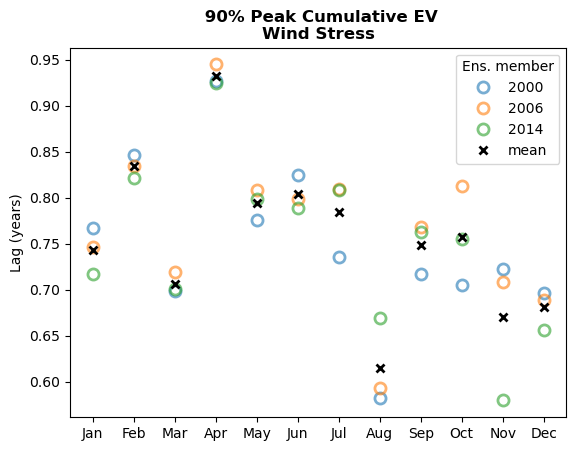

In [87]:
plot_var ='wind_OCE'
plt.figure()
pp2=evb_ds[plot_var].plot(x='month',add_legend=False,hue='eyear',marker='o',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)
pp1=evb_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='x',ls='',markeredgewidth=2,color='k')
plt.title(f' 90% Peak Cumulative EV\n{plotvar_labels[plot_var]}',fontweight='bold',fontsize=12)
plt.ylabel('Lag (years)')
#plt.ylim([1,-3])
plt.xticks(np.arange(1,13),mth)
plt.xlabel('')
plt.legend(eyears+['mean',],title='Ens. member')

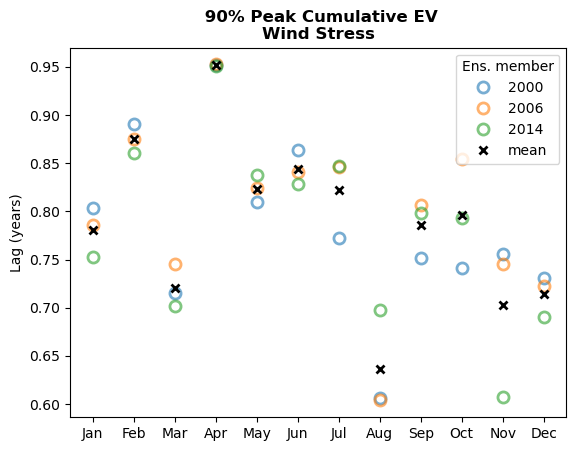

In [88]:
plot_var ='wind_OCE'
plt.figure()
pp2=ev_ds[plot_var].plot(x='month',add_legend=False,hue='eyear',marker='o',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)
pp1=ev_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='x',ls='',markeredgewidth=2,color='k')
plt.title(f' 90% Peak Cumulative EV\n{plotvar_labels[plot_var]}',fontweight='bold',fontsize=12)
plt.ylabel('Lag (years)')
#plt.ylim([1,-3])
plt.xticks(np.arange(1,13),mth)
plt.xlabel('')
plt.legend(eyears+['mean',],title='Ens. member')

In [75]:
for var in plotvars:
    print(f'{var} {lag_total[var].mean("eyear").data:1.3f} {lag_total[var].std("eyear").data:1.3f}')

all_OCE -2.136 0.840
wind_OCE -1.676 0.189
adxx_qnetXoceQnet_sum -0.424 0.043
adxx_empmrXoceFWflx_sum -4.459 0.129


In [82]:
lagb_ds['wind_OCE'].mean('month')*12

<xarray.DataArray 'wind_OCE' (eyear: 3)> Size: 24B
array([-7.38398357, -7.54277892, -9.93839836])
Coordinates:
    transp   <U2 8B 'fw'
  * eyear    (eyear) <U4 48B '2000' '2006' '2014'
    TRANSP   <U2 8B 'fw'

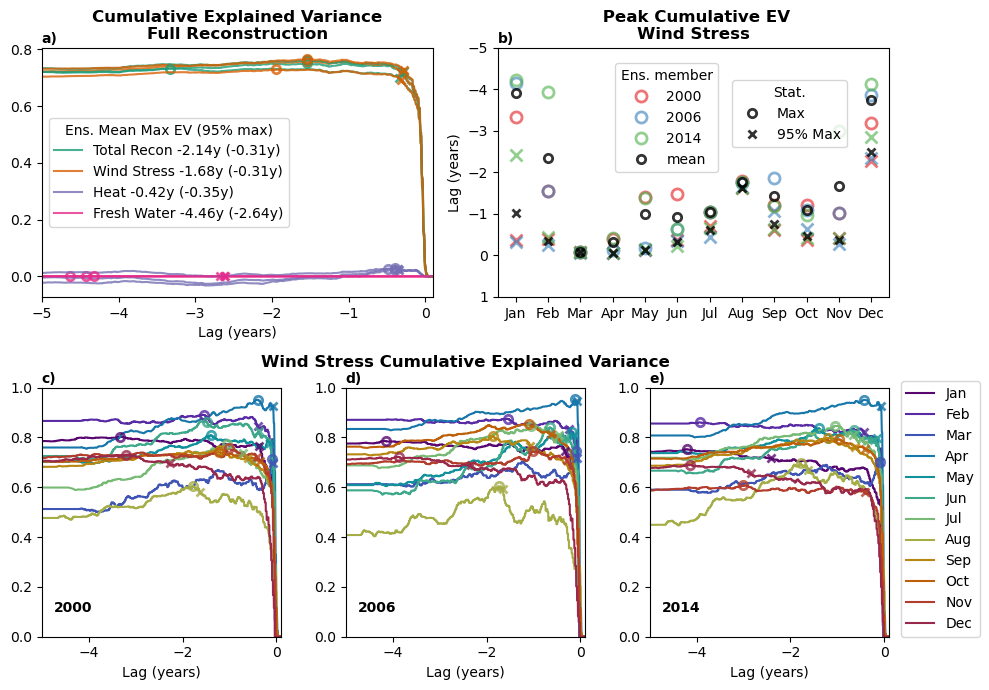

In [90]:
plt.figure(figsize=[10,7])

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
colors=plt.get_cmap('Dark2')
for year in eyears:
    pps=[]
    for iv,var in enumerate(plotvars):
        p1=cum_ev[year][var].plot(label=var,color=colors(iv),alpha=0.8)
        p2=ax1.plot(lag_total[var].sel(eyear=year),ev_total[var].sel(eyear=year),'o',color=colors(iv),alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        p2=ax1.plot(lagb_total[var].sel(eyear=year),evb_total[var].sel(eyear=year),'x',color=colors(iv),alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        pps.append(p1[0])

plt.legend(pps,[f'{plotvar_labels[x]} {lag_total[x].mean("eyear").data:1.2f}y ({lagb_total[x].mean("eyear").data:1.2f}y)' for x in plotvars],title='Ens. Mean Max EV (95% max)')
plt.title(f'Cumulative Explained Variance\nFull Reconstruction',fontweight='bold',fontsize=12)
plt.ylabel('')
plt.xlabel('Lag (years)')
plt.xlim([-5,0.1])
plt.text(0.0,1.02,'a)',fontsize=10,fontweight='bold',transform=ax1.transAxes)

colors=plt.get_cmap('Set1')
ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
plot_var='wind_OCE'
pp1=[]
for iy,year in enumerate(eyears):
    pp1.append(lag_ds[plot_var].sel(eyear=year).plot(x='month',add_legend=False,color=colors(iy),marker='o',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)[0])
    pp2=lagb_ds[plot_var].sel(eyear=year).plot(x='month',add_legend=False,color=colors(iy),marker='x',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)
pp3=lag_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='o',ls='',markeredgewidth=2,color='k',markerfacecolor='none',alpha=0.8)[0]
pp4=lagb_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='x',ls='',markeredgewidth=2,color='k',alpha=0.8)[0]
plt.title(f' Peak Cumulative EV\nWind Stress',fontweight='bold',fontsize=12)
plt.ylabel('Lag (years)')
plt.ylim([1,-5])
plt.xticks(np.arange(1,13),mth)
plt.xlabel('')
l1=plt.legend(pp1+[pp3,],eyears+['mean'],title='Ens. member',loc=[0.3,0.5])
plt.legend([pp3,pp4],['Max','95% Max'],title='Stat.',loc=[0.6,0.6])
ax2.add_artist(l1)
plt.text(0.0,1.02,'b)',fontsize=10,fontweight='bold',transform=ax2.transAxes)

cmap = cmr.take_cmap_colors('cmr.infinity', 12,cmap_range=(0,0.85))
custom_cycler = cycler(color=cmap)

labels=['c)','d)','e)']
bkgd=[0.6,0.8,0.6]
for iy,year in enumerate(eyears):
    iax=plt.subplot2grid((2,6),(1,iy*2),colspan=2)
   # iax.set_facecolor(bkgd)
    plt.text(0.0,1.02,labels[iy],fontsize=10,fontweight='bold',transform=iax.transAxes)
    iax.set_prop_cycle(custom_cycler)
    cum_ev_bym[year][plot_var].sel(month=range(1,13)).plot(x='lag_years',hue='exp',add_legend=False)
    for imth in range(1,13):
        iax.plot(lag_ds[plot_var].sel(eyear=year,month=imth),ev_ds[plot_var].sel(eyear=year,month=imth),'o',color=cmap[imth-1],alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        iax.plot(lagb_ds[plot_var].sel(eyear=year,month=imth),evb_ds[plot_var].sel(eyear=year,month=imth),'x',color=cmap[imth-1],alpha=0.8,markeredgewidth=2,markerfacecolor='none')
    plt.text(0.05,0.1,f'{year}',fontweight='bold',transform=iax.transAxes)
    plt.xlabel('Lag (years)')
    plt.ylabel('')
    plt.ylim([0,1])
    plt.xlim([-5,0.1])
    if iy==1:
        plt.title('Wind Stress Cumulative Explained Variance',fontweight='bold',y=1.05)
    else:
        plt.title('')
plt.legend(mth,loc=[1.05,0],
       #    facecolor=bkgd
          )

plt.tight_layout()
plt.savefig(f'../plots/fig3_cumev_timeseries_peaks.pdf',bbox_inches='tight')